# 网络的验证

这种验证其实也就有些类似于目标检测的验证了，比分类问题复杂些，通过一些指标而非简单的分类标签来判定真伪。

如果先不看ggcnn中的思路，这块让我来做的话，分析一下，我们得到的网络输出是pos_img,ang_img和width_img，pos_img各点的值可以视作该点可抓不可抓的概率，图像大小为（300，300），太多了，那么我首先可以把最大值的1000个点筛选出来，然后找对对应的angle和width，凭借这三个参数就可以重建出这些点的抓取框，然后计算与真实各框的iou和jaccard指数等，如果都满足标准，就认为这是一次正确的抓取，这次预测也就是正确的了。

那就开整，流程应该是这样的：
- 首先是从网络的输出映射图中反求出各个实际参数代表的抓取框，主要就是要将cos和sin两个图反求出angle。
- 然后要明确一下成功的标准，然后写函数计算这些标准，最后再集成到类或者函数里面，思路还是很明确的。
  - 1.IoU>某个阈值
  - 2.jaccard index
  - 3.angle<某个阈值（即使重合度很高，角度差太远也是不行的）
 
最后，与之前程序的结合之处应当这样写：先对网络进行训练，每隔一定时间，执行验证函数，验证函数需要从外部载入的只有验证集数据和刚刚训练过的网络模型，在验证函数内部对验证集中的样本进行逐一预测，计算前面所设计的两个指标，如果满足，则正确样本数加1，最后的正确率=正确样本数/验证集样本总数。

## 1.原始输出数据的处理及其中有效抓取框的提取
此处注意，思路应当是这样的，先提取出所有的有效抓取框，也即，抓取概率为1的抓取框都应该提取出来作为候选，至于这些框中的哪些是正确的，就交由后面的两个指标来判断

### 1.1原始输出数据的处理
首先是通过原始的输出映射四张图把数据读出来，这边我们先运行一个训练，得到一下训练输出，然后方便处理

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from cornell_pro import Cornell
from ggcnn import GGCNN

#准备数据集
cornell_data = Cornell('../cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 32)

#从数据集中读取一个样本
for x,y,_ in dataset:
    xc = x
    yc = y
    break
    
#实例化一个网络
net = GGCNN(4)

#定义一个优化器
optimizer = optim.Adam(net.parameters())

#为了能够看出效果，就在这个样本上多训练几次，得到一个很擅长这个样本的模型，然后拿它做预测输出

for i in range(300):
    losses = net.compute_loss(xc,yc)
    
    loss = losses['loss']
    print(i,loss)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()



0 tensor(0.9671, grad_fn=<AddBackward0>)
1 tensor(0.9379, grad_fn=<AddBackward0>)
2 tensor(0.9026, grad_fn=<AddBackward0>)
3 tensor(0.8516, grad_fn=<AddBackward0>)
4 tensor(0.7736, grad_fn=<AddBackward0>)
5 tensor(0.6559, grad_fn=<AddBackward0>)
6 tensor(0.4903, grad_fn=<AddBackward0>)
7 tensor(0.2900, grad_fn=<AddBackward0>)
8 tensor(0.1399, grad_fn=<AddBackward0>)
9 tensor(0.2660, grad_fn=<AddBackward0>)
10 tensor(0.3036, grad_fn=<AddBackward0>)
11 tensor(0.1883, grad_fn=<AddBackward0>)
12 tensor(0.1120, grad_fn=<AddBackward0>)
13 tensor(0.1099, grad_fn=<AddBackward0>)
14 tensor(0.1398, grad_fn=<AddBackward0>)
15 tensor(0.1664, grad_fn=<AddBackward0>)
16 tensor(0.1760, grad_fn=<AddBackward0>)
17 tensor(0.1678, grad_fn=<AddBackward0>)
18 tensor(0.1465, grad_fn=<AddBackward0>)
19 tensor(0.1198, grad_fn=<AddBackward0>)
20 tensor(0.0995, grad_fn=<AddBackward0>)
21 tensor(0.0988, grad_fn=<AddBackward0>)
22 tensor(0.1133, grad_fn=<AddBackward0>)
23 tensor(0.1204, grad_fn=<AddBackward0>)
24

194 tensor(0.0359, grad_fn=<AddBackward0>)
195 tensor(0.0359, grad_fn=<AddBackward0>)
196 tensor(0.0358, grad_fn=<AddBackward0>)
197 tensor(0.0357, grad_fn=<AddBackward0>)
198 tensor(0.0357, grad_fn=<AddBackward0>)
199 tensor(0.0356, grad_fn=<AddBackward0>)
200 tensor(0.0356, grad_fn=<AddBackward0>)
201 tensor(0.0355, grad_fn=<AddBackward0>)
202 tensor(0.0355, grad_fn=<AddBackward0>)
203 tensor(0.0354, grad_fn=<AddBackward0>)
204 tensor(0.0354, grad_fn=<AddBackward0>)
205 tensor(0.0353, grad_fn=<AddBackward0>)
206 tensor(0.0353, grad_fn=<AddBackward0>)
207 tensor(0.0353, grad_fn=<AddBackward0>)
208 tensor(0.0353, grad_fn=<AddBackward0>)
209 tensor(0.0354, grad_fn=<AddBackward0>)
210 tensor(0.0355, grad_fn=<AddBackward0>)
211 tensor(0.0353, grad_fn=<AddBackward0>)
212 tensor(0.0351, grad_fn=<AddBackward0>)
213 tensor(0.0349, grad_fn=<AddBackward0>)
214 tensor(0.0349, grad_fn=<AddBackward0>)
215 tensor(0.0349, grad_fn=<AddBackward0>)
216 tensor(0.0349, grad_fn=<AddBackward0>)
217 tensor(

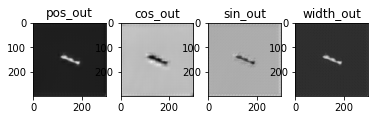

In [2]:
#将输入传递到网络并计算输出
pos,cos,sin,width = net.forward(xc)

#可视化看一下输出是是一个相对合理的预测
num = 20

plt.subplot(141)
plt.title('pos_out')
plt.imshow(pos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(142)
plt.title('cos_out')
plt.imshow(cos[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(143)
plt.title('sin_out')
plt.imshow(sin[num][0].data.numpy(),cmap=plt.cm.gray)
plt.subplot(144)
plt.title('width_out')
plt.imshow(width[num][0].data.numpy(),cmap=plt.cm.gray)
plt.show()

看起来还不错，下面开始数据的读取和反求。

首先是反求一下角度数据，同时对三个数据进行一下降维处理。

In [3]:
q_img = pos.data.numpy().squeeze()#squeeze的作用通过处理前后张量的shape就可以看出来，对于单通道的图像，可视化以及后面计算的时候是不要需要第三个维度的，所以去掉了
ang_img = (torch.atan2(sin, cos) / 2.0).data.numpy().squeeze()
width_img = width.data.numpy().squeeze()

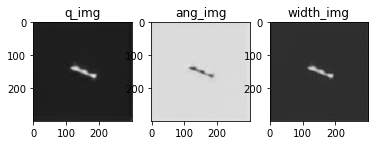

In [4]:
#可视化一下看看效果，主要是看ang_img，其他俩都没变
plt.subplot(131)
plt.title('q_img')
plt.imshow(q_img[num],cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img')
plt.imshow(ang_img[num],cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img')
plt.imshow(width_img[num],cmap=plt.cm.gray)
plt.show()

在真正计算之前，还需要进行一个高斯滤波，原因论文中已经说过了，前面已经可视化了滤波之前的效果，后面滤波一下，然后再看效果

In [5]:
from skimage.filters import gaussian
#注意此处要加上一个索引，也就是传入一个样本到gaussian函数，q_img[num],而不能将q_img整个传入，否则后面的运算会出问题，guassian这个函数无法批量处理多样本，
q_img_g = gaussian(q_img[num], 2.0, preserve_range=True)
ang_img_g = gaussian(ang_img[num], 2.0, preserve_range=True)
width_img_g = gaussian(width_img[num], 1.0, preserve_range=True)

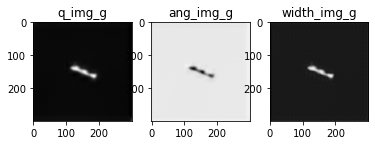

In [6]:
#可视化一下看看高斯滤波后的效果
plt.subplot(131)
plt.title('q_img_g')
plt.imshow(q_img_g,cmap=plt.cm.gray)
plt.subplot(132)
plt.title('ang_img_g')
plt.imshow(ang_img_g,cmap=plt.cm.gray)
plt.subplot(133)
plt.title('width_img_g')
plt.imshow(width_img_g,cmap=plt.cm.gray)
plt.show()

可以看到输出平滑了许多，而且对比度也有所增加，具体的效果可以后面再做对比实验比对，但作者是做了对比实验的，经过高斯过滤后动态抓取效果要好很多。

### 1.2有效抓取的提取
这块按照我的想法就是设置一个阈值，比如1，使用np.where()函数就可以找出所有满足这个阈值的点坐标，然后挨个把他们对应的其他两个参数读出来，这样定义一个抓取的所有三个参数就都有了，可以把它构造成前面设计的Grasp类，再处理的话就方便多了。

我看ggcnn的思路也是类似，但是对于最开始的有效点的提取，他直接用了一个函数peak_local_max，来自skimage.feature,我觉得可以学习一下，具体学习过程见support files，这里就直接拿来用了：

In [7]:
from skimage.feature import peak_local_max
#变量的命名就沿用ggcnn里面的了
local_max = peak_local_max(q_img_g, min_distance=20, threshold_abs=0.1,num_peaks = 1)

In [8]:
local_max

array([[163, 184]], dtype=int64)

可以看到，这边直接按照ggcnn默认的参数来执行的话，是没有返回值的，原因肯定在于threshold_abs这个参数，因为我们可以看到可视化的图里面有局部极值，那么一定就是这个threshold_abs设置的太大了（虽然图中看着很亮，对比挺明显的，但可能是matplotlib自己可视化时做的优化），下面检查一下q_img的取值范围。

In [9]:
q_img_g.min()

-0.021621471

In [10]:
q_img_g.max()

0.5807601

Bingo！

就是因为预测出的值太小了，没有达到我们设定的峰值最低标准threshold，最根本的原因在于训练的迭代次数太少了，只有五十次，通过spyder程序测试后发现，loss会迅速下降，但q_img的max值在250次迭代左右才会达到比较理想的量级（同理这50次迭代出的angle和width偏差也是有些大，不要被可视化的图像迷惑了），如下图所示:
![loss_max](..\images\loss_and_max_value.png)（这个图片可以通过调用train_main2.py来获得，迭代了1000次）

而实际训练中的迭代次数是远超200次的，所以，没问题，这个问题可以暂时忽略，对最终结果无影响，下面就暂时把threshold_abs设为0.01，接着往下进行：

In [11]:
local_max = peak_local_max(q_img_g, min_distance=20, threshold_abs=0.04, num_peaks = 1)
print(local_max)

[[163 184]]


这里返回的是q_img中极值点的坐标，我们可以通过这个坐标读出该点的角度，宽度等数据，然后将其重建为一个抓取框对象Grasp_cpaw

In [12]:
for grasp_point_array in local_max:
    grasp_point = tuple(grasp_point_array)
    grasp_angle = ang_img_g[grasp_point]
    grasp_width = width_img_g[grasp_point]

In [13]:
print(grasp_angle)
print(grasp_width)
width_img_g.max()

-0.105296314
0.23696469


0.23696469

在数据集的处理中，是将width这个参数缩小了150倍的，刚才读取了一下

下面使用这两个参数将其构造为一个Grasp_cpaw对象

到这就有些问题了，因为前面的极值点在数量级上不符合要求的话，没关系，调节阈值，将相对最大的值找出来就可以了，但是angle和width在50次的迭代过程后的结果也是不准的，这是会直接影响到我构建出的抓取框形状姿态的，直接用这个不精确的值肯定会出问题，而在这边迭代250次以上又太慢了，所以我直接用spyder迭代了1000次，去它预测的angle和width结果过来使用，如下代码。

In [14]:
from grasp_pro import Grasp_cpaw

#这是经过1000次迭代后预测出的值
angle = -0.10458073
width = 0.4398

g = Grasp_cpaw(grasp_point,angle,width)#是可以不指定grasp.length的。
#到这对象就构建好了，完成了从输出中提取一个有效抓取框的过程，可以将它们集成到一个函数里面去

In [15]:
def detect_grasps(q_img, ang_img, width_img=None, no_grasps=1):
    '''
    :功能: 从给定的网络预测输出中提取有效的抓取框
    :参数: q_img     : Tensor,经过处理的网络pos预测输出
    :参数: angle     : Tensor,从网络输出的cos和sin值中计算得来的角度值
    :参数: width_img : Tensor,经过处理的网络width预测输出
    :参数: no_grasp  : int,期望得到的抓取框的个数
    :返回: grasps    : list,包含提取到的多个抓取框类的列表
    '''
    
    local_max = peak_local_max(q_img, min_distance=20, threshold_abs=0.01, num_peaks=no_grasps)#实际使用时记得把这个阈值改大点
    
    grasps = []
    for grasp_point_array in local_max:
        grasp_point = tuple(grasp_point_array)
        grasp_angle = ang_img_g[grasp_point]
    
    g = Grasp_cpaw(grasp_point, grasp_angle)#width下一句再指定
    if width_img is not None:
        g.width = width_img[grasp_point]
        g.length = g.width/2
    grasps.append(g)
    
    return grasps

In [16]:
grasps = detect_grasps(q_img_g,ang_img_g,width_img_g)

In [17]:
grasps[0].angle = -0.10458073
grasps[0].width = 0.4398*150 #将其缩放到正常的范围
grasps[0].length = grasps[0].width/2

print(grasps[0].center)
print(grasps[0].angle)
print(grasps[0].width)
print(grasps[0].length)

(163, 184)
-0.10458073
65.97
32.985


提取出本次预测的最优的抓取框之后，就可以通过比较它和真实标注之间的一些指标来判断这次预测的抓取是否为正确的，下面看这些指标的计算方式。

## 2.标准的确定
### 2.1 IoU的计算
全称Intersection over Union
![IoU计算示意图](..\images/iou.png)

计算IoU程序的设计思路可以参考：https://blog.csdn.net/u014061630/article/details/82818112

先不考虑具体细节实施的话，这块的流程可以总结为一下几点：
- 从网络输出中提取出面向本样本所有的有效抓取框（通过q_img来判定，这个工作前面已完成）
- 从原始数据集中获取该样本的真实标注Grasps，对于每一个有效抓取框，计算其与真实标注中每一个标注框的iou值，角度等指标是否符合标准，如果各项标注都符合，则认为这个预测框是正确的，进而认为本次预测是正确的。

好的，开整

 首先，必须得清楚，iou这个指标是相对而言的，肯定是两个抓取框之间才会有iou的计算，提取到的抓取框本身是一个了，还要给它输入一个抓取框才行，这里给它输入一个包含当前id所有真实标注框的列表，循环比对去计算，只要它跟其中一个框的iou满足要求了，就认为这个预测是正确的。

iou的计算本质上是通过面积的大小来进行的，面积的大小又要通过像素点的多少来体现，提取矩形内部像素点的方法可以用之前用过的polygon函数，为了好看，我们直接生成空白的图片，然后将里面的抓取框可视化出来。

In [18]:
#把这个样本的几个真实的点找出来供后面计算对比，这块的对比直接去读yc里面的话，太多了，所以还是从默认的标注里面读取，把那几个原始的标注框用作对比就好了。
import glob
import os
from grasp_pro import Grasps
idx = 0

cornell_path = '../cornell'

graspf = glob.glob(os.path.join(cornell_path,'*','pcd*cpos.txt'))
graspf.sort()

rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]

grasp_true = Grasps.load_from_cornell_files(graspf[idx])
print(grasp_true.center//2)
print(grasp_true.points)
print(grasp_true.points-grasp_true.center//2)

[142 151]
[array([[253, 320],
       [309, 324],
       [307, 350],
       [251, 346]]), array([[255, 325],
       [308, 332],
       [313, 295],
       [260, 288]]), array([[260, 303],
       [311, 309],
       [314, 283],
       [263, 277]]), array([[258, 279],
       [320, 282],
       [321, 261],
       [259, 258]])]
[[[111 169]
  [167 173]
  [165 199]
  [109 195]]

 [[113 174]
  [166 181]
  [171 144]
  [118 137]]

 [[118 152]
  [169 158]
  [172 132]
  [121 126]]

 [[116 128]
  [178 131]
  [179 110]
  [117 107]]]


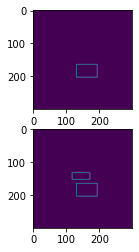

In [19]:
#假设有两张大小为300X300的图片a,b，里面各包含一个抓取矩形，我们现在要计算这两个矩形的iou
import cv2
#首先生成这两张图片（生成图片只是为了可视化好看，其实计算iou只通过矩形角点坐标就可以实现了，不需要放在一个图片里面）
a = np.zeros([300,300])

#读取抓取框的数据，还是用真实的数据来操作吧
a_points = grasps[0].as_gr.points.astype(np.uint8)#预测出的抓取
b_points = grasp_true.points[2]-grasp_true.center//2#真实的抓取，可以先测试一下跟哪个标注框的重合度较高，然后拿好的那个来计算

#print(a_points)
#print(b_points)

#给图片添加抓取矩形
a = cv2.rectangle(a,tuple(a_points[0]),tuple(a_points[2]),2)
plt.subplot(211)
plt.imshow(a)

cv2.rectangle(a,tuple(b_points[0]),tuple(b_points[2]),2)

plt.subplot(212)
plt.imshow(a)
plt.show()
plt.imsave('a.png',a)

下面计算iou

In [20]:
from skimage.draw import polygon
#先提取出两个框各自的覆盖区域
rr1, cc1 = grasps[0].as_gr.polygon_coords()#现在是中心点和角度定义的抓取，要转换成四个角点定义的抓取才方便操作
rr2, cc2 = polygon(b_points[:, 0], b_points[:, 1])

#读取两个框的极限位置
r_max = max(rr1.max(),rr2.max())+1
c_max = max(cc1.max(),cc2.max())+1

上面的操作就是提取出了远的角点，在上面的例子中，就是这个红圈圈出来的点。
![max_iou](../images/max_iou.png)

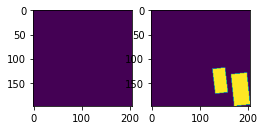

In [21]:
#计算公共区域大小，这个画布其实只需要到达边界即可，因为iou是相对的，绝对大小多少不重要
#生成画布
canvas = np.zeros((r_max,c_max))

plt.subplot(131)
plt.imshow(canvas)
canvas[rr1,cc1] += 1
canvas[rr2,cc2] += 1 
plt.subplot(132)
plt.imshow(canvas)
plt.show()

图中黄色区域就是公共区域intersection，黄绿一起的就是两个框总共覆盖的union。

In [22]:
#读出两个区域的具体面积
union = np.sum(canvas > 0)
intersection = np.sum(canvas == 2)

#计算iou
print('iou = %.3f' % (intersection/union))

iou = 0.000


可以看到，iou>0.25，甚至都大于0.5了，满足标准而且是一次比较成功的预测。

至此，针对任意包含抓取矩形，在已知其角点的情况下的iou计算已经完成，图片确实是任意的，但其中包含的矩形是用的真实数据，这个不影响的。

下面把这部分集成到一个函数里面

In [23]:
def iou(g,g_true):
    '''
    :功能 :        计算两个给定框的iou
    :参数 : g     :Grasp对象，预测结果中反求出的抓取框
    :参数 : g_true:Grasp对象，真实标注抓取框
    :返回 : 两者的iou
    '''
    #先提取出两个框的所覆盖区域
    rr1, cc1 = g.polygon_coords()#现在是中心点和角度定义的抓取，要转换成四个角点定义的抓取才方便操作
    rr2, cc2 = polygon(g_true.points[:, 0], g_true.points[:, 1])
    
    #读取两个框的极限位置
    r_max = max(rr1.max(),rr2.max())+1
    c_max = max(cc1.max(),cc2.max())+1
    
    #根据最大的边界来确定蒙版画布大小
    canvas = np.zeros((r_max,c_max))
    canvas[rr1,cc1] += 1
    canvas[rr2,cc2] += 1
    
    union = np.sum(canvas > 0)
    
    if union == 0:
        return 0
    
    intersection = np.sum(canvas == 2)
    return intersection/union